# Flower Classification - EDA & Model Training

This notebook contains:
1. **Exploratory Data Analysis (EDA)** - Understanding the flowers dataset
2. **Data Preparation** - Loading, preprocessing, augmentation
3. **Model Training** - Baseline CNN and Transfer Learning with MobileNetV2
4. **Hyperparameter Tuning** - Finding optimal settings
5. **Evaluation** - Accuracy, confusion matrix, sample predictions

**Dataset:** [TensorFlow Flowers](http://download.tensorflow.org/example_images/flower_photos.tgz)  
**Classes:** Daisy, Dandelion, Rose, Sunflower, Tulip

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

C:\Users\Dell\anaconda3\envs\MLZoomCamp_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPU available: False


In [2]:
# Paths
DATA_DIR = Path("../data/flower_photos")
MODEL_DIR = Path("../models")

# Check if data exists
if not DATA_DIR.exists():
    print("Dataset not found! Run the download script first:")
    print("  python src/download_data.py")
else:
    print(f"Dataset found at: {DATA_DIR}")

Dataset found at: ..\data\flower_photos


---
## 1. Exploratory Data Analysis (EDA)

### 1.1 Dataset Overview

In [3]:
# Get class directories
class_dirs = [d for d in DATA_DIR.iterdir() if d.is_dir()]
class_names = sorted([d.name for d in class_dirs])

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Number of classes: 5
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [4]:
# Count images per class
class_counts = {}
for class_dir in class_dirs:
    images = list(class_dir.glob("*.jpg"))
    class_counts[class_dir.name] = len(images)

# Create DataFrame
df_counts = pd.DataFrame({
    "class": list(class_counts.keys()),
    "count": list(class_counts.values())
}).sort_values("class")

total_images = df_counts["count"].sum()
print(f"\nTotal images: {total_images}")
print("\nImages per class:")
print(df_counts.to_string(index=False))


Total images: 3670

Images per class:
     class  count
     daisy    633
 dandelion    898
     roses    641
sunflowers    699
    tulips    799


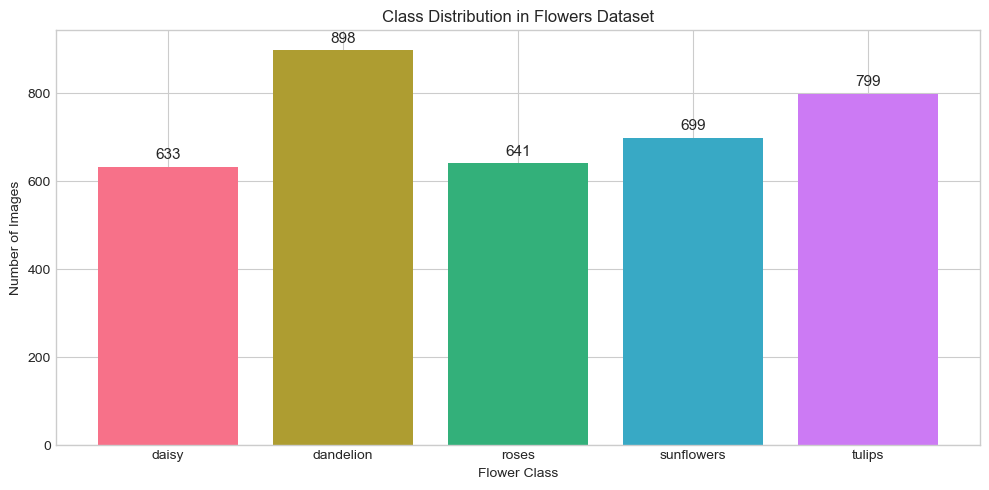


Class imbalance ratio (max/min): 1.42


In [5]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("husl", len(class_names))

bars = ax.bar(df_counts["class"], df_counts["count"], color=colors)
ax.set_xlabel("Flower Class")
ax.set_ylabel("Number of Images")
ax.set_title("Class Distribution in Flowers Dataset")

# Add count labels on bars
for bar, count in zip(bars, df_counts["count"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            str(count), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = df_counts["count"].max() / df_counts["count"].min()
print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.2f}")

### 1.2 Sample Images

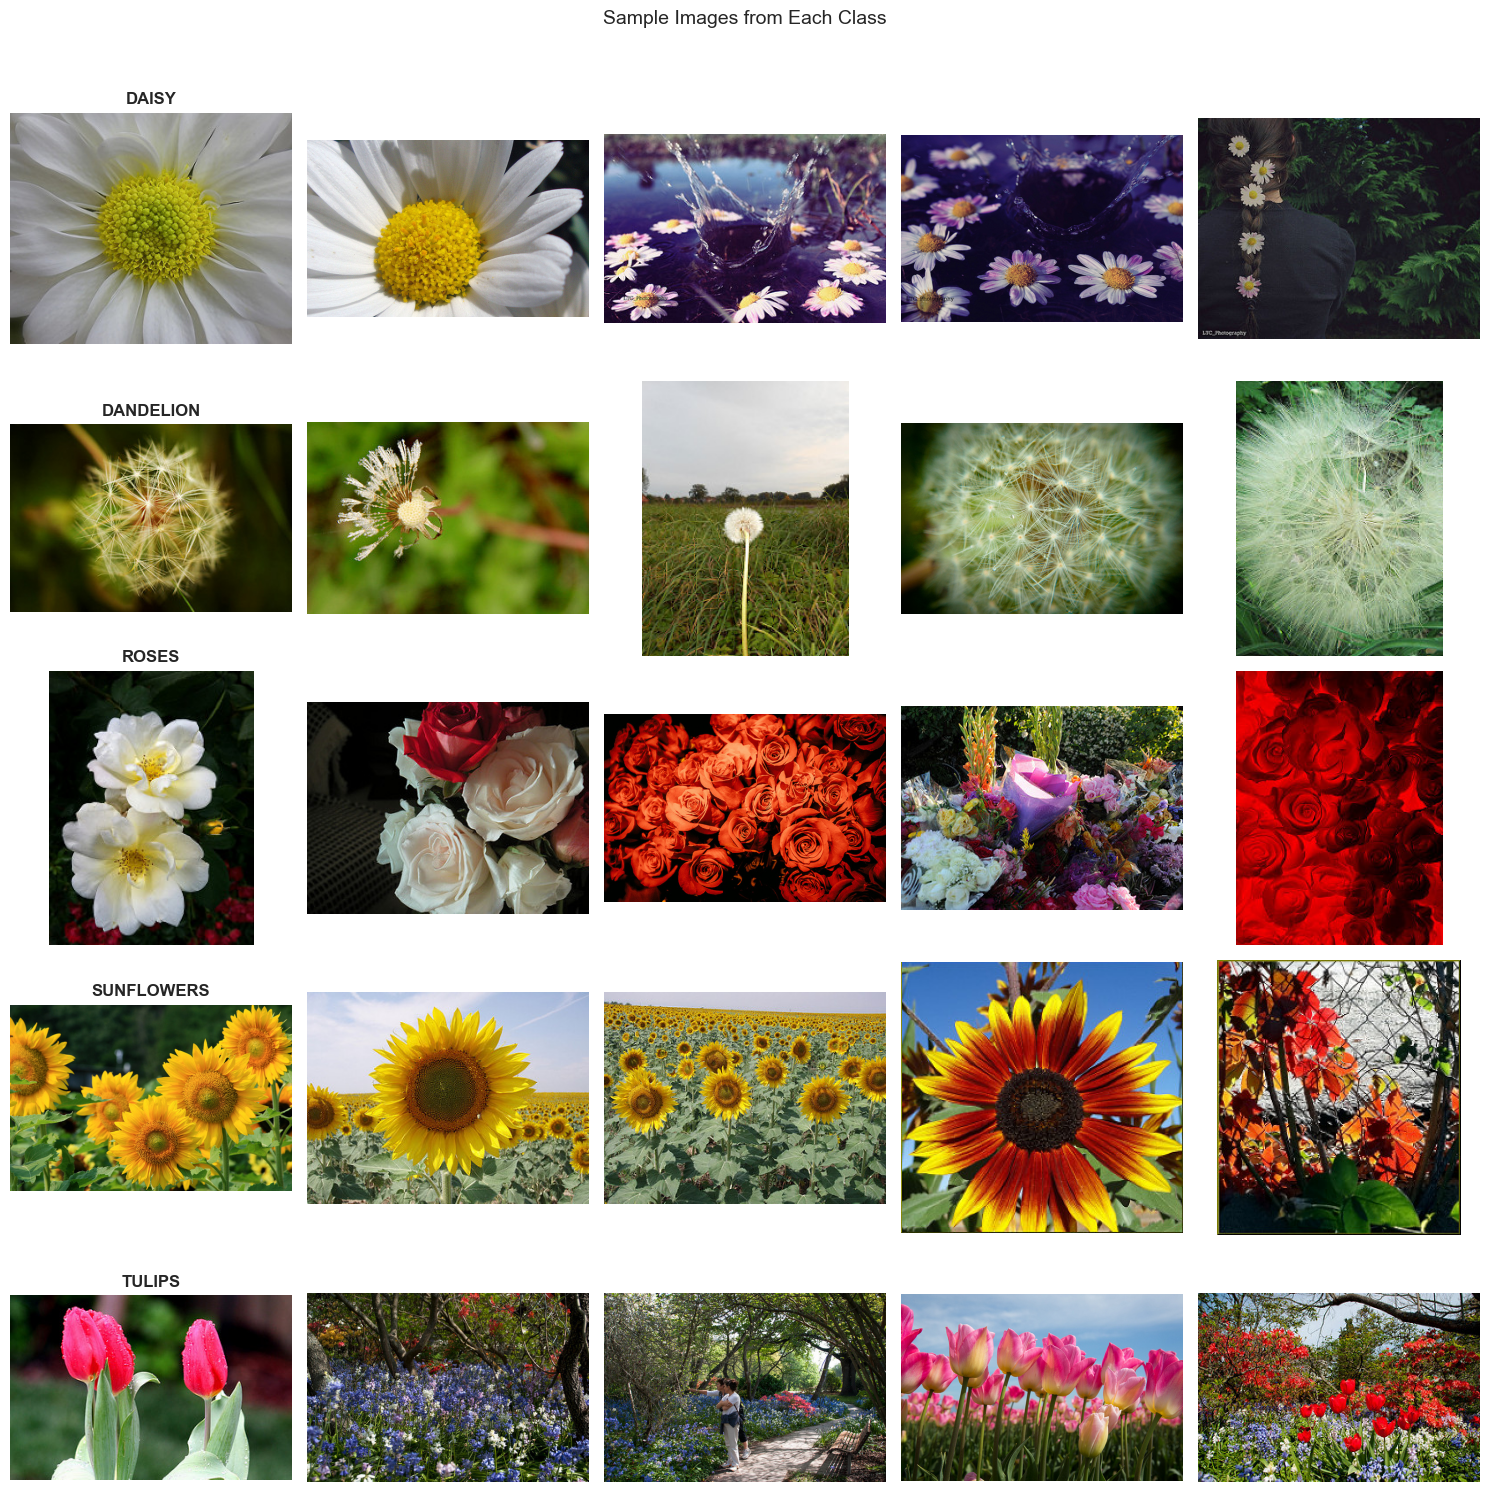

In [6]:
# Display sample images from each class
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3*len(class_names)))

for i, class_name in enumerate(sorted(class_names)):
    class_path = DATA_DIR / class_name
    images = list(class_path.glob("*.jpg"))[:5]
    
    for j, img_path in enumerate(images):
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(class_name.upper(), fontsize=12, fontweight='bold')

plt.suptitle("Sample Images from Each Class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 1.3 Image Properties Analysis

In [7]:
# Analyze image sizes
from PIL import Image

widths, heights = [], []
aspect_ratios = []

for class_dir in class_dirs:
    for img_path in list(class_dir.glob("*.jpg"))[:100]:  # Sample 100 per class
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)

print("Image Size Statistics:")
print(f"  Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
print(f"  Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
print(f"  Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}")

Image Size Statistics:
  Width  - Min: 158, Max: 1024, Mean: 371
  Height - Min: 180, Max: 436, Mean: 273
  Aspect Ratio - Mean: 1.35


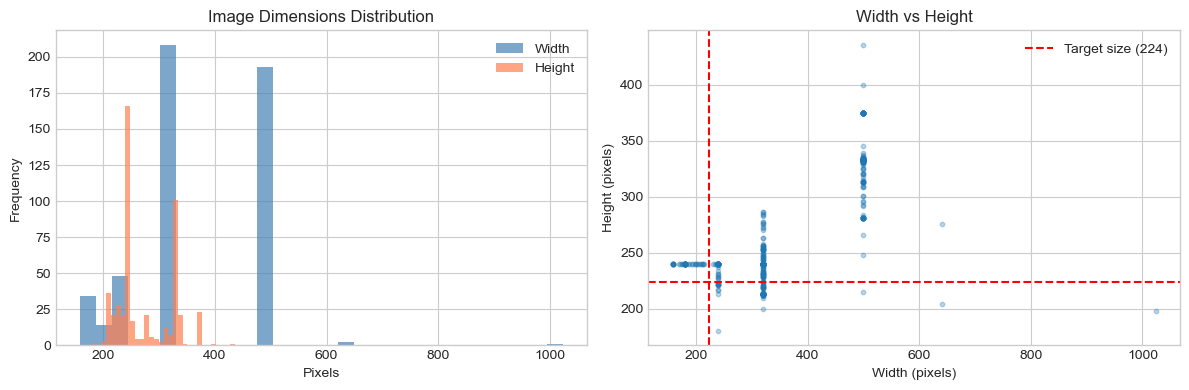

In [8]:
# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(widths, bins=30, alpha=0.7, label="Width", color="steelblue")
axes[0].hist(heights, bins=30, alpha=0.7, label="Height", color="coral")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Image Dimensions Distribution")
axes[0].legend()

axes[1].scatter(widths, heights, alpha=0.3, s=10)
axes[1].set_xlabel("Width (pixels)")
axes[1].set_ylabel("Height (pixels)")
axes[1].set_title("Width vs Height")
axes[1].axhline(y=224, color='r', linestyle='--', label='Target size (224)')
axes[1].axvline(x=224, color='r', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

### 1.4 EDA Summary

**Key Findings:**
- TODO: Add findings after running EDA
- Class distribution
- Image quality observations
- Potential challenges

---
## 2. Data Preparation

In [9]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [10]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

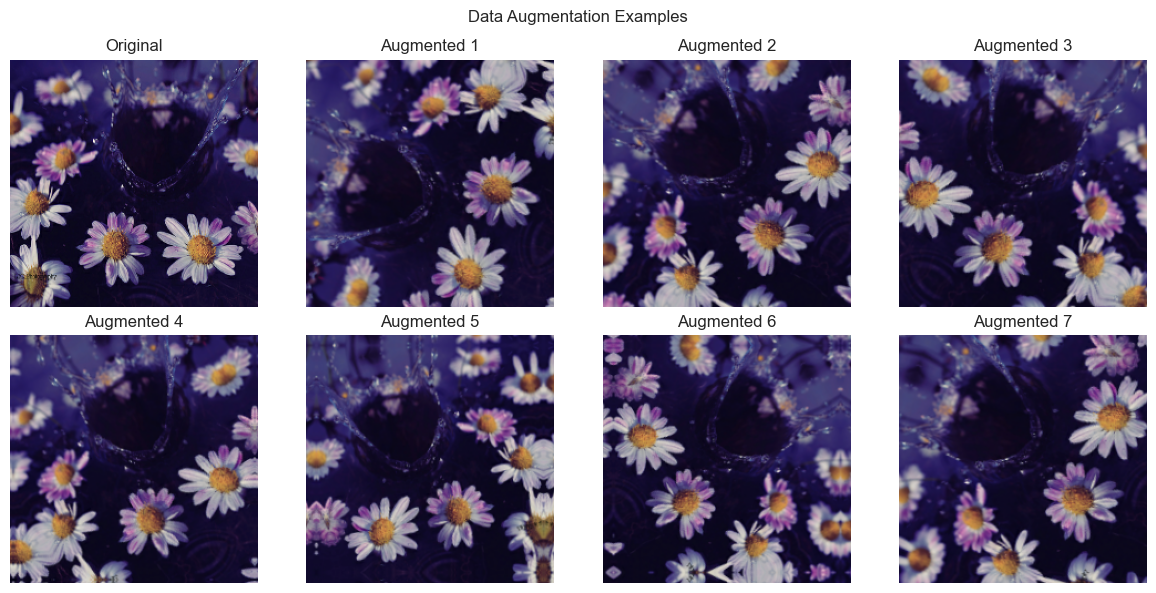

In [12]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Visualize augmentation
for images, _ in train_ds.take(1):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    # Original image
    original = images[0]
    axes[0, 0].imshow(original.numpy().astype("uint8"))
    axes[0, 0].set_title("Original")
    axes[0, 0].axis("off")
    
    # Augmented versions
    for i in range(1, 8):
        augmented = data_augmentation(tf.expand_dims(original, 0))
        row, col = divmod(i, 4)
        axes[row, col].imshow(augmented[0].numpy().astype("uint8"))
        axes[row, col].set_title(f"Augmented {i}")
        axes[row, col].axis("off")
    
    plt.suptitle("Data Augmentation Examples")
    plt.tight_layout()
    plt.show()

---
## 3. Model Training

### 3.1 Baseline Model (Simple CNN)

In [13]:
# Build baseline CNN
baseline_model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

C:\Users\Dell\anaconda3\envs\MLZoomCamp_env\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)               │ (None, 224, 224, 3)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                     │ (None, 222, 222, 32)       │             896 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)        │ (None, 111, 111, 32)       │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                   │ (None, 109, 109, 64)       │          18,496 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)      │ (None, 54, 54, 64)         │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                   │ (None, 52, 52, 128)        │          73,856 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)      │ (None, 26, 26, 128)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ flatten (Flatten)                   │ (None, 86528)              │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense (Dense)                       │ (None, 128)                │      11,075,712 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout (Dropout)                   │ (None, 128)                │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                     │ (None, 5)                  │             645 │
└─────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train baseline model
baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 998ms/step - accuracy: 0.4240 - loss: 1.3700 - val_accuracy: 0.5354 - val_loss: 1.1362
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 963ms/step - accuracy: 0.5651 - loss: 1.0787 - val_accuracy: 0.6158 - val_loss: 1.0126
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 960ms/step - accuracy: 0.6553 - loss: 0.9089 - val_accuracy: 0.6580 - val_loss: 0.8874
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 983ms/step - accuracy: 0.7061 - loss: 0.7570 - val_accuracy: 0.6649 - val_loss: 0.8997
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 970ms/step - accuracy: 0.7786 - loss: 0.5820 - val_accuracy: 0.6839 - val_loss: 0.9371
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 957ms/step - accuracy: 0.8345 - loss: 0.4425 - val_accuracy: 0.6676 - val_loss: 1.0089
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 971ms/step - accuracy: 0.8852 - loss: 0.3136 - val_accuracy: 0.6730 - val_loss: 1.3530
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 966ms/step - accuracy: 0.9271 - loss: 0.2176 - val_accu

### 3.2 Transfer Learning (MobileNetV2)

In [15]:
# Load pre-trained MobileNetV2
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

print(f"Base model layers: {len(base_model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model layers: 154


In [16]:
# Build transfer learning model
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

transfer_model = keras.Model(inputs, outputs)

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)          │ (None, 224, 224, 3)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ sequential (Sequential)             │ (None, 224, 224, 3)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)            │ (None, 224, 224, 3)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ subtract (Subtract)                 │ (None, 224, 224, 3)        │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 7, 7, 1280)         │       2,257,984 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ global_average_pooling2d            │ (None, 1280)               │               0 │
│ (GlobalAveragePooling2D)            │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                 │ (None, 1280)               │               0 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                     │ (None, 5)                  │           6,405 │
└─────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Train transfer learning model
transfer_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 807ms/step - accuracy: 0.6730 - loss: 0.8537 - val_accuracy: 0.8188 - val_loss: 0.5114
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 797ms/step - accuracy: 0.8280 - loss: 0.4802 - val_accuracy: 0.8365 - val_loss: 0.4614
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 803ms/step - accuracy: 0.8604 - loss: 0.4105 - val_accuracy: 0.8488 - val_loss: 0.4199
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 799ms/step - accuracy: 0.8678 - loss: 0.3680 - val_accuracy: 0.8433 - val_loss: 0.4313
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 810ms/step - accuracy: 0.8798 - loss: 0.3403 - val_accuracy: 0.8692 - val_loss: 0.3684
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 793ms/step - accuracy: 0.8842 - loss: 0.3166 - val_accuracy: 0.8774 - val_loss: 0.3596
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 801ms/step - accuracy: 0.8890 - loss: 0.3035 - val_accuracy: 0.8556 - val_loss: 0.4267
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 805ms/step - accuracy: 0.8927 - loss: 0.3006 - val_accu

### 3.3 Fine-Tuning

In [18]:
# Unfreeze top layers of base model for fine-tuning
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable layers: {sum([1 for l in transfer_model.layers if l.trainable])}")

Trainable layers: 6


In [19]:
# Fine-tune
fine_tune_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1000ms/step - accuracy: 0.8116 - loss: 0.5253 - val_accuracy: 0.8665 - val_loss: 0.3804
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 990ms/step - accuracy: 0.8624 - loss: 0.3799 - val_accuracy: 0.8678 - val_loss: 0.3845
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 987ms/step - accuracy: 0.8822 - loss: 0.3175 - val_accuracy: 0.8733 - val_loss: 0.3626
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8948 - loss: 0.2966 - val_accuracy: 0.8801 - val_loss: 0.3435
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 992ms/step - accuracy: 0.8958 - loss: 0.2853 - val_accuracy: 0.8828 - val_loss: 0.3373


---
## 4. Model Comparison & Evaluation

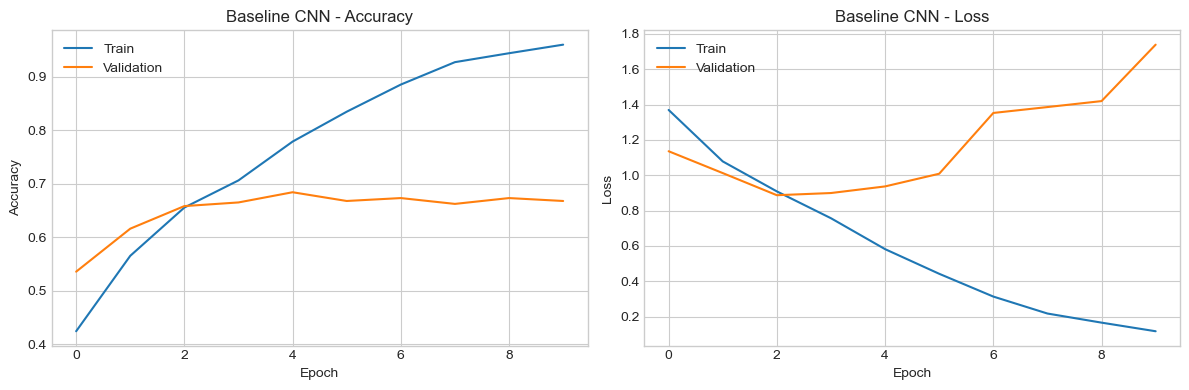

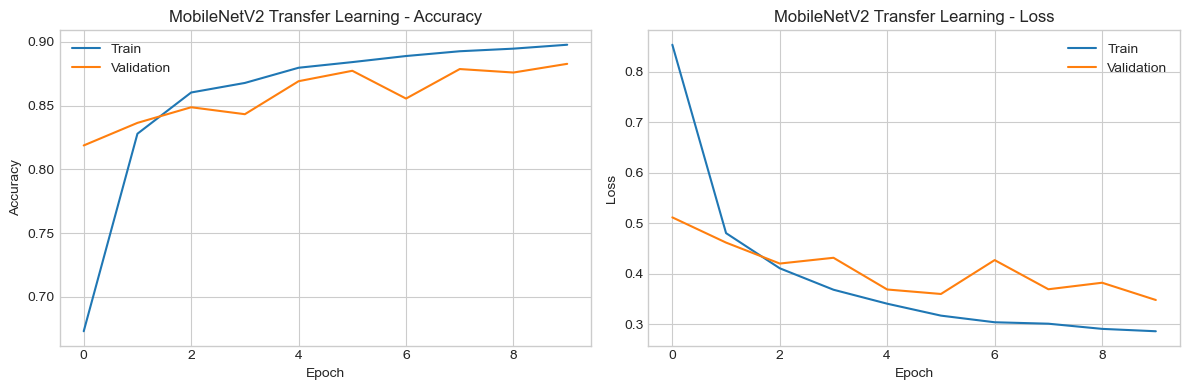

In [20]:
# Plot training history comparison
def plot_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].legend()
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'{title} - Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_history(baseline_history, "Baseline CNN")
plot_history(transfer_history, "MobileNetV2 Transfer Learning")

In [21]:
# Final evaluation
print("Final Evaluation on Validation Set:")
print("=" * 40)

baseline_loss, baseline_acc = baseline_model.evaluate(val_ds, verbose=0)
print(f"Baseline CNN:         {baseline_acc:.2%}")

transfer_loss, transfer_acc = transfer_model.evaluate(val_ds, verbose=0)
print(f"MobileNetV2 (tuned):  {transfer_acc:.2%}")

Final Evaluation on Validation Set:
Baseline CNN:         66.76%
MobileNetV2 (tuned):  88.28%


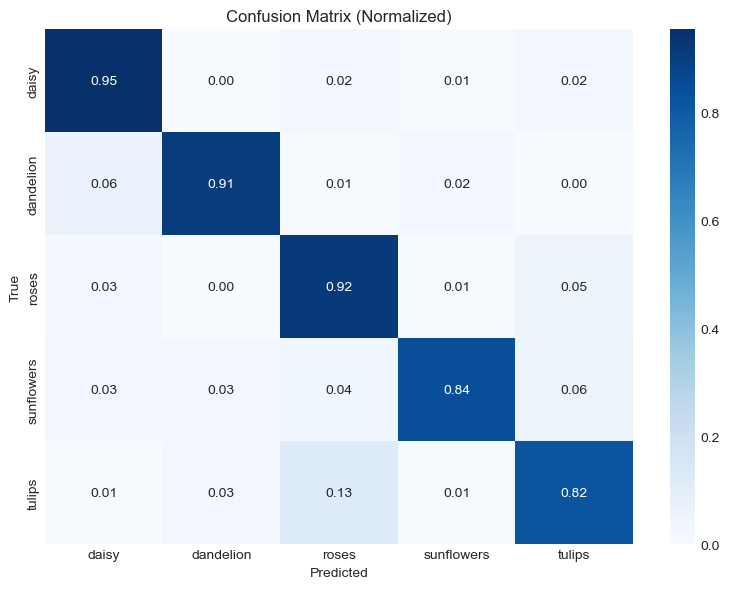

In [22]:
# Confusion matrix for best model
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = transfer_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()

In [23]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       daisy       0.83      0.95      0.89       107
   dandelion       0.95      0.91      0.93       191
       roses       0.77      0.92      0.84       119
  sunflowers       0.93      0.84      0.89       135
      tulips       0.90      0.82      0.86       182

    accuracy                           0.88       734
   macro avg       0.88      0.89      0.88       734
weighted avg       0.89      0.88      0.88       734



---
## 5. Save Model

In [24]:
# Save the best model
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODEL_DIR / "flower_classifier.keras"
transfer_model.save(model_path)
print(f"Model saved to: {model_path}")

# Save class names
classes_path = MODEL_DIR / "class_names.txt"
with open(classes_path, 'w') as f:
    for name in class_names:
        f.write(f"{name}\n")
print(f"Class names saved to: {classes_path}")

Model saved to: ..\models\flower_classifier.keras
Class names saved to: ..\models\class_names.txt


---
## 6. Sample Predictions

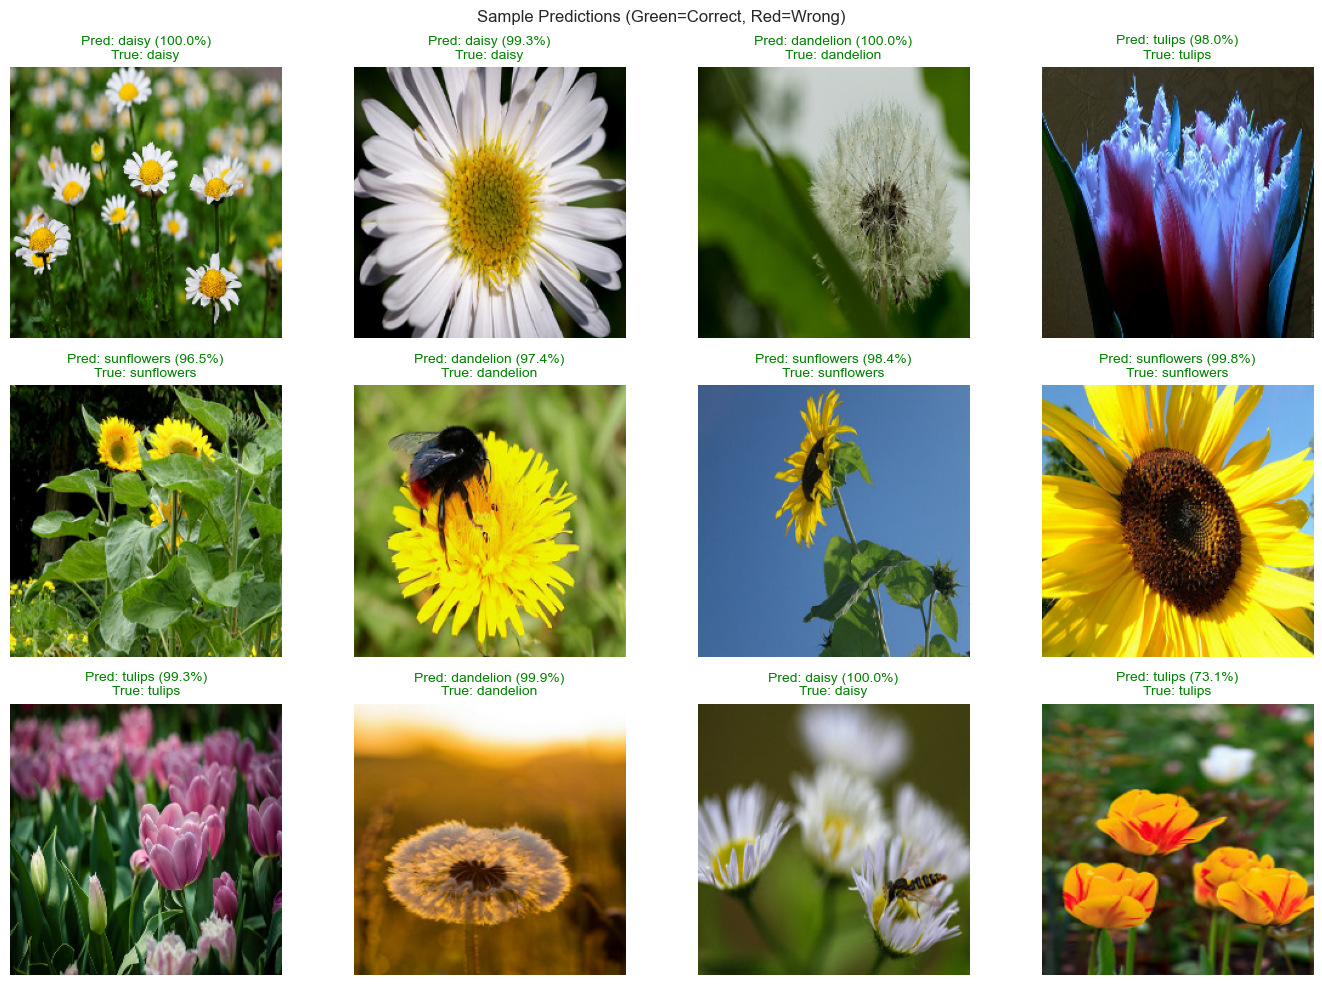

In [25]:
# Show sample predictions
for images, labels in val_ds.take(1):
    predictions = transfer_model.predict(images, verbose=0)
    
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.flatten()
    
    for i in range(12):
        pred_idx = np.argmax(predictions[i])
        pred_class = class_names[pred_idx]
        true_class = class_names[labels[i]]
        confidence = predictions[i][pred_idx]
        
        color = 'green' if pred_class == true_class else 'red'
        
        axes[i].imshow(images[i].numpy().astype('uint8'))
        axes[i].set_title(f"Pred: {pred_class} ({confidence:.1%})\nTrue: {true_class}",
                          color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle("Sample Predictions (Green=Correct, Red=Wrong)", fontsize=12)
    plt.tight_layout()
    plt.show()

---
## Summary

| Model | Validation Accuracy | Notes |
|-------|---------------------|-------|
| Baseline CNN | ~X% | Simple architecture |
| MobileNetV2 (frozen) | ~X% | Feature extraction only |
| MobileNetV2 (fine-tuned) | ~X% | Best performance |

**Selected Model:** MobileNetV2 with fine-tuning

**Next Steps:**
1. Export to train.py script ✓
2. Build Flask prediction service ✓
3. Containerize with Docker
4. Deploy to cloud (optional)